In [85]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import japanize_matplotlib
from os.path import join
from settings import geodatadir
import itertools
from shapely.geometry import Point, LineString, MultiLineString
D = 'GeoJSON'
geojson = 'GeoJSON'
# 地図は背景に地理院地図（国土地理院）を使用している場合があります。

In [2]:
# mesh_codes = list(itertools.chain.from_iterable(
#     [(np.array([5237, 5238, 5239, 5240]) + xx) for xx in [0, 100, 200, 300, 400]])) + \
#         [5738, 5739, 5740, 5741, 5641, 5541]
# ans = gpd.GeoDataFrame()
# for x in mesh_codes:
#     x = gpd.read_file(join(geodatadir, f'mesh500/HDDSWH{x}/MESH0{x}.shp'))
#     ans = pd.concat([ans, x])
# ans


In [3]:
mesh = gpd.read_file('data/kanto-kouiki-mesh/kanto-kouiki-mesh.shp', crs=4612).to_crs(2451)

In [4]:
kokusei = pd.DataFrame()
for x in mesh.MESH1_ID.unique():
    kokusei = pd.concat([kokusei,
        pd.read_csv(join(geodatadir, f"kokutyou500/tblT000847H{x}.txt"), encoding='sjis', skiprows=[1])])
kokusei = kokusei[['KEY_CODE', 'T000847001']]
kokusei.columns = ['KEY_CODE', 'people']
kokusei.KEY_CODE = kokusei.KEY_CODE.astype(str)
kokusei = pd.merge(mesh[['KEY_CODE', 'geometry']], kokusei, on='KEY_CODE')
kokusei['area_t'] = kokusei.area

In [68]:
keizai = pd.DataFrame()
for x in mesh.MESH1_ID.unique():
    keizai = pd.concat([keizai,
        pd.read_csv(join(geodatadir, f"keizai500/tblT000389H{x}.txt"), encoding='sjis', skiprows=[1])])
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai = pd.merge(mesh, keizai, on='KEY_CODE')
keizai['area_t'] = keizai.area

In [6]:
stations = gpd.read_file(join(geodatadir, '../ekidata/ekidata.geojson'), crs=4326).to_crs(2451)

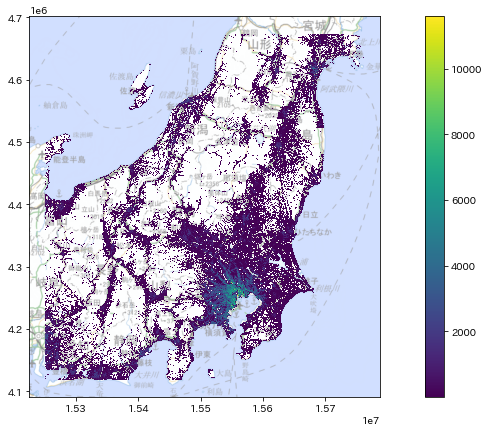

In [ ]:
# ax = kokusei.to_crs(3857).plot('people', legend=True, figsize=(16, 7))
# cx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png', alpha=0.7)

In [19]:
stations_buffer = stations.copy()
stations_buffer.geometry = stations.geometry.buffer(1500)
x = gpd.overlay(kokusei, stations_buffer)
x['ans'] = x.people * (x.area / x.area_t)
x = x.groupby('station_cd').sum().reset_index()[['station_cd', 'ans']]
ekijinko = pd.merge(stations, x, on='station_cd')

In [39]:
taisyou = gpd.read_file('../data/kyokai/shikutyoson1/japan_rvis_h25.shp', encoding='sjis')
taisyou.crs = "epsg:4326"
taisyou['pref'] = taisyou.JCODE.str[:2]
taisyou = taisyou.to_crs(2451)
taisyou

,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,JCODE,P_NUM,H_NUM,geometry,pref
0,北海道,None,None,札幌市,中央区,01101,220189.0,120596.0,"POLYGON ((126749.563 785895.185, 126541.507 78...",01
1,北海道,None,None,札幌市,北区,01102,278781.0,127291.0,"POLYGON ((127777.071 799349.565, 127945.562 79...",01
2,北海道,None,None,札幌市,東区,01103,255873.0,118804.0,"POLYGON ((131414.914 796433.266, 131348.771 79...",01
3,北海道,None,None,札幌市,白石区,01104,204259.0,100343.0,"POLYGON ((133516.915 789082.471, 131723.130 78...",01
4,北海道,None,None,札幌市,豊平区,01105,212118.0,107084.0,"POLYGON ((130458.446 781241.369, 130432.758 78...",01
...,...,...,...,...,...,...,...,...,...,...
1902,沖縄県,None,島尻郡,None,久米島町,47361,8519.0,3598.0,"MULTIPOLYGON (((-1147757.478 -844795.395, -114...",47
1903,沖縄県,None,島尻郡,None,八重瀬町,47362,26681.0,8118.0,"MULTIPOLYGON (((-1216980.420 -1031295.606, -12...",47
1904,沖縄県,None,宮古郡,None,多良間村,47375,1231.0,498.0,"MULTIPOLYGON (((-1544099.810 -1159400.170, -15...",47
1905,沖縄県,None,八重山郡,None,竹富町,47381,3859.0,1997.0,"MULTIPOLYGON (((-1637899.930 -1181063.322, -16...",47


In [43]:
taisyou = taisyou.dropna(subset=['pref']).copy()
taisyou.pref = taisyou.pref.astype(int)
taisyou = taisyou[taisyou.pref.isin([7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20])]
taisyou

,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,JCODE,P_NUM,H_NUM,geometry,pref
363,福島県,None,None,None,福島市,07201,292590.0,112854.0,"POLYGON ((52346.108 217047.476, 52378.686 2170...",7
364,福島県,None,None,None,会津若松市,07202,126220.0,47813.0,"POLYGON ((8402.663 175166.740, 8525.985 175145...",7
365,福島県,None,None,None,郡山市,07203,338712.0,131548.0,"POLYGON ((40233.987 179937.334, 40255.266 1797...",7
366,福島県,None,None,None,いわき市,07204,342249.0,128480.0,"MULTIPOLYGON (((78868.166 146788.180, 78946.14...",7
367,福島県,None,None,None,白河市,07205,64704.0,22697.0,"POLYGON ((27225.450 139179.800, 27298.483 1391...",7
...,...,...,...,...,...,...,...,...,...,...
967,長野県,None,下高井郡,None,野沢温泉村,20563,3853.0,1220.0,"POLYGON ((-117164.962 110075.504, -117007.491 ...",20
968,長野県,None,上水内郡,None,信濃町,20583,9238.0,3239.0,"POLYGON ((-141489.236 97123.674, -141214.888 9...",20
969,長野県,None,上水内郡,None,小川村,20588,3041.0,1150.0,"POLYGON ((-168722.381 76189.695, -168541.663 7...",20
970,長野県,None,上水内郡,None,飯綱町,20590,11865.0,3776.0,"POLYGON ((-138931.617 93972.859, -138913.309 9...",20


In [22]:
# ans = []
# for x in ekijinko.geometry:
#     ans.append(taisyou.geometry.distance(x).sort_values()[0])
# ekijinko['taisyou'] = ans

In [60]:
po2 = ekijinko.copy().drop(['taisyou'], 1).query('company_cd == 2').drop_duplicates(subset='station_g_cd')
po2 = gpd.overlay(po2, taisyou[['geometry']])
po2.ans = round(po2.ans).astype(int)
po2 = po2.sort_values('ans', ascending=False).reset_index().drop('index', 1)
po2['rank'] = po2.index + 1

In [50]:
po2.to_file('output/kanto-kouiki-jr-rank.geojson', driver='GeoJSON')

In [57]:
po2[po2['rank'] >= 1000]

,company_cd,company_name,line_cd,line_name,line_name_h,station_cd,station_g_cd,station_name,e_sort,ans,geometry,rank
999,2,JR東日本,11408,JR越後線,JR越後線,1140808,1140808,石地,1140808,667.807403,POINT (-101280.741 165297.877),1000
1000,2,JR東日本,11325,JR内房線,JR内房線,1132517,1132517,竹岡,1132517,650.254888,POINT (-289.052 -89020.643),1001
1001,2,JR東日本,11228,ゆうゆうあぶくまライン,JR磐越東線,1122806,1122806,夏井,1122806,645.587613,POINT (73558.101 139366.555),1002
1002,2,JR東日本,11407,JR飯山線,JR飯山線,1140723,1140723,越後田中,1140723,640.622539,POINT (-107356.578 112227.367),1003
1003,2,JR東日本,11225,JR磐越西線(郡山～会津若松),JR磐越西線(郡山～会津若松),1122511,1122511,翁島,1122511,633.539955,POINT (19503.833 172329.388),1004
...,...,...,...,...,...,...,...,...,...,...,...,...
1084,2,JR東日本,11216,山形線,JR奥羽本線(福島～新庄),1121604,1121604,赤岩,1121604,17.000000,POINT (44222.352 200484.526),1085
1085,2,JR東日本,11227,JR只見線,JR只見線,1122731,1122731,柿ノ木,1122731,16.000000,POINT (-65921.800 149079.150),1086
1086,2,JR東日本,11342,JR上越線,JR上越線,1134216,1134216,土合,1134216,2.000000,POINT (-77191.976 92519.856),1087
1087,2,JR東日本,11230,JR常磐線(いわき～仙台),JR常磐線(いわき～仙台),1123014,1123014,桃内,1132066,1.000000,POINT (101732.032 170245.921),1088


In [62]:
po2[['line_name_h', 'station_name', 'ans']].to_csv('kantou-kouiki-rank.csv', index=None)

In [75]:
x = po2.copy()
x.geometry = x.geometry.buffer(1000)
x = gpd.overlay(keizai, x)
x['syugyo'] = round(x.people * (x.area / x.area_t)).astype(int)
x = x.groupby('station_cd').sum().reset_index()[['station_cd', 'syugyo']]
po3 = pd.merge(po2, x, on='station_cd')

In [84]:
po3['disp'] = po3.station_name + ' / ' + po3.ans.astype(str) + ' / ' + po3.syugyo.astype(str)
po3.iloc[:, 4:]

,line_name_h,station_cd,station_g_cd,station_name,e_sort,ans,geometry,rank,syugyo,disp
0,JR埼京線,1132106,1132106,板橋,1132106,171523,POINT (-10294.857 -28236.879),1,27158,板橋 / 171523 / 27158
1,JR中央・総武緩行線,1131308,1131308,東中野,1131308,166796,POINT (-13473.354 -32548.978),2,31127,東中野 / 166796 / 31127
2,JR中央・総武緩行線,1131323,1131323,亀戸,1131323,164492,POINT (-639.941 -33578.067),3,46122,亀戸 / 164492 / 46122
3,JR京浜東北線,1133230,1133230,蒲田,1133230,163901,POINT (-10633.365 -48529.721),4,51629,蒲田 / 163901 / 51629
4,JR横須賀線,1130804,1130804,西大井,1130804,162605,POINT (-10112.015 -44192.668),5,22171,西大井 / 162605 / 22171
...,...,...,...,...,...,...,...,...,...,...
1083,JR上越線,1134217,1134217,土樽,1134217,25,POINT (-86642.918 97558.260),1084,5,土樽 / 25 / 5
1084,JR只見線,1122731,1122731,柿ノ木,1122731,16,POINT (-65921.800 149079.150),1086,36,柿ノ木 / 16 / 36
1085,JR上越線,1134216,1134216,土合,1134216,2,POINT (-77191.976 92519.856),1087,27,土合 / 2 / 27
1086,JR常磐線(いわき～仙台),1123015,1123015,小高,1132067,1,POINT (102747.591 174067.923),1088,1702,小高 / 1 / 1702


In [86]:
po3.to_file('kanto-kouiki-rank-2.geojson', geojson)